In [9]:
import base64
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

## Research on Disparity Refinement by Optimal Transportation


### 1. Introduction to Optimal Transport


Optimal Transport (OT) theory is a branch of mathematics that deals with the problem of finding the most efficient way to move mass from one distribution to another. The origins of OT can be traced back to Gaspard Monge in the 18th century, but the modern formulation and its widespread application owe much to the work of Leonid Kantorovich in the 20th century.


The fundamental problem of OT can be described as follows: Given two distributions of mass in some space, find the mapping that transports one distribution to the other while minimizing the total cost of transportation. This cost is typically defined in terms of a distance function, which measures the effort required to move mass from one point to another.


#### Key Concepts:


- **Monge's Problem**: The original formulation by Monge seeks a map that directly transports mass in a way that minimizes transportation costs.
- **Kantorovich's Relaxation**: Kantorovich proposed a relaxation of Monge's problem, allowing for partial transport and introducing a probabilistic interpretation. This leads to a problem that is more tractable computationally.


#### Mathematical Formulation:


- **Monge Formulation**: Given distributions $\mu$ and $\nu$ on spaces $X$ and $Y$, find a transport map $T$: $X \rightarrow Y$ that minimizes the cost $\int_X c(x, T(x))d\mu(x) $, subject to $T_{\#\mu}=\nu$, where $c(x, y)$ is the cost of moving mass from $x$ to $y$.
  
- **Kantorovich Formulation**: Minimize $\int_{X \times Y} c(x, y) d\gamma(x, y)$ over all joint distributions $\gamma$ on $X \times Y$ with marginals $\mu$ and $\nu$, respectively.
  


### 2. Disparity Refinement by Optimal Transports.


#### Application to Disparity Refinement:


- **Problem Statement**: Given an initial disparity map obtained from stereo images, the task is to refine this map to improve its accuracy. This refinement process involves adjusting disparities to better align with the actual geometry of the scene, often marred by noise and other inaccuracies in initial estimations. Then we get our AGG output of disparity map $D_{a}$ and the neural network output of disparity map $D_d$. The aim of disparity refinement is to adjust $D_a$ to a more visual-friendly, edge-smoothing $D^{\prime}$ with $D_d$
  
- **OT in Disparity Refinement**: Optimal transport is used to minimize the disparity distribution's deviation from the initial estimation, subject to spatial consistency and smoothness constraints. This approach can be understood as finding a transportation plan that aligns the initial and refined disparity distributions while minimizing a given cost function, which often incorporates terms for spatial coherence and smoothness.
  


#### Implementation:


- **Cost Function**: Designing an appropriate cost function is crucial. It should reflect the disparity's transportation cost between initial and refined estimates while also incorporating penalties for spatial discontinuities. This cost function can incorporate both the difference in disparity values and the spatial distance to encourage smoothness.
  
- **Optimization Problem**: The objective is to find the refined disparity map $D^{\prime}$ that minimizes the total transportation cost:
  
  $$
  \min _{D^{\prime}} \int_{X \times Y} c\left((x, y),\left(x^{\prime}, y^{\prime}\right)\right) d \gamma\left((x, y),\left(x^{\prime}, y^{\prime}\right)\right)
  $$


- **Computational Methods**: Solving the OT problem for disparity refinement requires efficient computational methods. Techniques like the Sinkhorn algorithm for entropy-regularized OT have been widely used due to their balance between accuracy and computational feasibility.

### Algorithm Pipeline

For convinient usage, let us call the raw input of AGG *Xs* and raw input of DL *Xt*.

- Downscale *Xs* and *Xt* to a smaller size
- Find the invalid pixels(let's say $D_{ij} < 10$), and mask them out on *Xt*.
- Normalize *Xs* and *Xt* with minmax method or normal method.
- Apply OT to generate *R*.
- Restore back *R* with $\mu_{X_s}$ and $\sigma_{X_s}$.
- Recheck $R$ by patch comparison.
- Final result.

In [10]:
mm(""" 
graph LR;
   A1(AGG)--downsample--> A2(AGGs);
   B1(DL)--downsample-->B2(DLs);
   C[mask out] -.find the invalid pixels.-> A2 & B2;
   A2(AGGs)--normalization-->A3(AGGn);
   B2(DLs)--normalization-->B3(DLn);
   A3 & B3 --OT--> R1(OT_res);
   R1 --restore--> R2(OT_restore);
   R2 --recheck--> R3(OT_final);
""")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import h5py
from skimage.transform import resize

### Common Functions and Variables

In [12]:
DATASET_NAME = 'data'

In [13]:
def load_disp_from_mat(path, dataset_name="data"):
    """load left disparity from .mat file."""
    with h5py.File(path, "r") as file:
        print("Keys: %s" % file.keys())
        dataset = file[dataset_name]
        disp = dataset[:]

    return disp

def image_resize(img, sz):
    return resize(img, sz)


def apply_colormap(z_vals, cmap_name='gray'):
    """
    Apply a colormap to a 2D numpy array and return the corresponding RGBA values.

    Parameters:
    - z_vals: 2D numpy array of scalar values.
    - cmap_name: String name of the colormap to use.

    Returns:
    - color_mapped: 3D numpy array with an RGBA color mapped from each z value.
    """
    # Normalize z_vals to the range [0, 1]
    norm = plt.Normalize(vmin=z_vals.min(), vmax=z_vals.max())
    
    # Get the colormap
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Apply the colormap (including normalization)
    color_mapped = cmap(norm(z_vals))
    
    return color_mapped

def figure_show(fig, idx=None, vmin=None, vmax=None, colorbar=False, title=None):
    if idx is None:
        plt.figure()
    else:
        plt.figure(idx)
    
    # If vmin and vmax are not provided, use the min and max values of the image.
    if vmin is None:
        vmin = fig.min()
    if vmax is None:
        vmax = fig.max()
    # Display the image with the specified vmin and vmax
    img = plt.imshow(fig, vmin=vmin, vmax=vmax, cmap='gray')
    # Add a colorbar with the correct scaling.
    if colorbar:
        plt.colorbar(img)
    if title is not None:
        plt.suptitle(title, fontsize=12)
    plt.show()

### For data 11

We first explore the effects on our input data 11.

In [14]:
ot_minmax_path_11 = '/Users/williamwei/Codes/disp-refine-by-DL/data/11/OT_minmax_0222_agg.mat'
ot_normal_path_11 = '/Users/williamwei/Codes/disp-refine-by-DL/data/11/OT_normal_0222_agg.mat'
scaled_agg_path_11 = '/Users/williamwei/Codes/disp-refine-by-DL/data/11/scaled_0222_agg.mat'
dl_path_11 = '/Users/williamwei/Codes/disp-refine-by-DL/data/11/output_0222_DL.npy'

We load the binary file into numpy arrary and dipict them with colormap to visualize.

In [15]:
minmax_11 = load_disp_from_mat(ot_minmax_path_11, DATASET_NAME)
normal_11 = load_disp_from_mat(ot_normal_path_11, DATASET_NAME)
scaled_agg_11 = load_disp_from_mat(scaled_agg_path_11, DATASET_NAME)
dl_11 = np.load(dl_path_11)
scaled_dl_11 = image_resize(dl_11, (scaled_agg_11.shape[0], scaled_agg_11.shape[1]))


cm_minmax_11 = apply_colormap(minmax_11)
cm_normal_11 = apply_colormap(normal_11)
cm_scaled_agg_11 = apply_colormap(scaled_agg_11)
cm_scaled_dl_11 = apply_colormap(scaled_dl_11)

Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


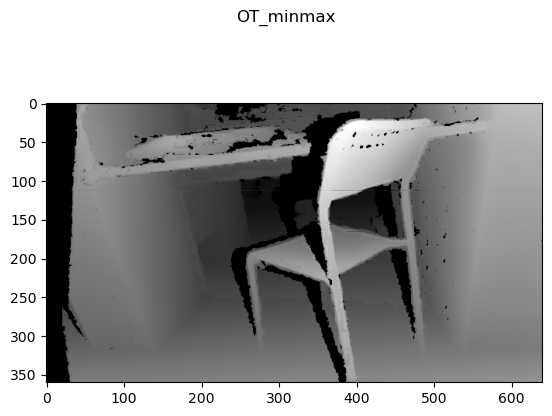

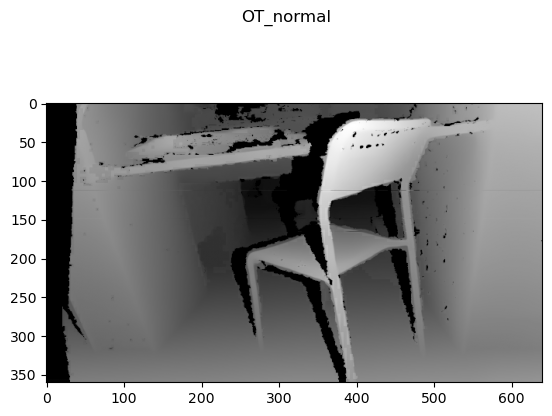

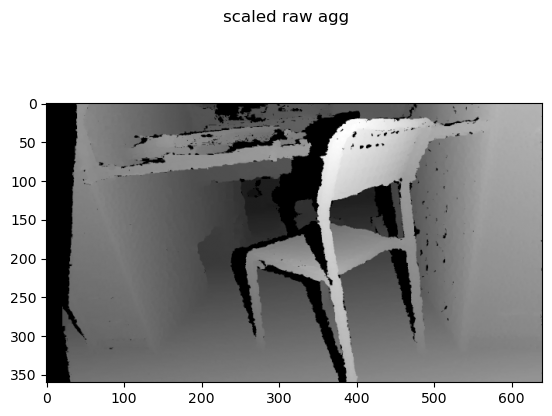

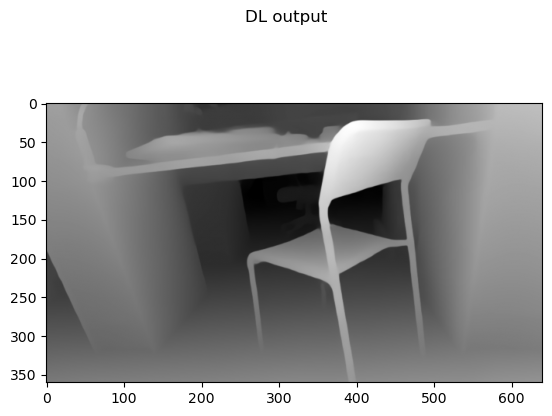

In [16]:
figure_show(cm_minmax_11, 1, title='OT_minmax')
figure_show(cm_normal_11, 2, title='OT_normal')
figure_show(cm_scaled_agg_11, 3, title='scaled raw agg')
figure_show(cm_scaled_dl_11, 4, title='DL output')

Now we want to find the maximum/minimum difference between the OT output and original AGG output as well as the location.

In [17]:
diff_minmax_agg_11 = minmax_11 - scaled_agg_11
diff_normal_agg_11 = normal_11 - scaled_agg_11

cm_diff_minmax_agg_11 = apply_colormap(diff_minmax_agg_11)
cm_diff_normal_agg_11 = apply_colormap(diff_normal_agg_11)

/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


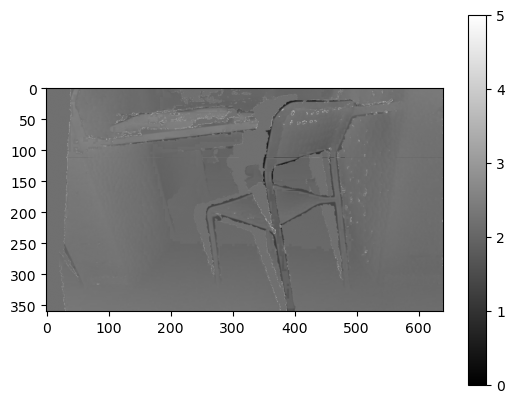

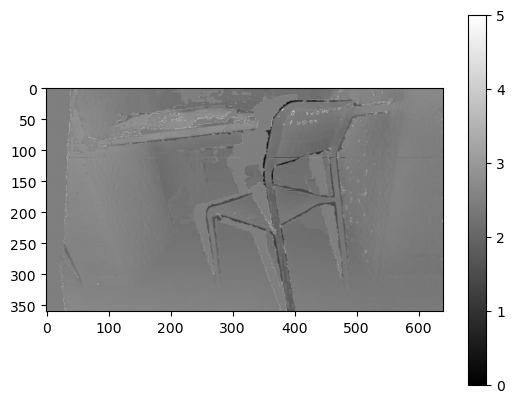

In [18]:
figure_show(cm_diff_minmax_agg_11, 1, 0, 5, True)
figure_show(cm_diff_normal_agg_11, 2, 0, 5, True)

In [19]:
print(f"The maxmimum difference between OT_minmax and agg is {np.max(diff_minmax_agg_11)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_11 == np.max(diff_minmax_agg_11))}")
print(f"The minimum difference between OT_minmax and agg is {np.min(diff_minmax_agg_11)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_11 == np.min(diff_minmax_agg_11))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_11)}, whereas the max value is {np.max(scaled_agg_11)}")
print(f"The min value of OT_minmax output is {np.min(minmax_11)}, whereas the max value is {np.max(minmax_11)}")

The maxmimum difference between OT_minmax and agg is 86.49973517724248
where with the subscripts of (array([55]), array([414]))
The minimum difference between OT_minmax and agg is -68.03463663223931
where with the subscripts of (array([227]), array([379]))
The min value of original AGG output is 0.0, whereas the max value is 140.99987514183766
The min value of OT_minmax output is 0.0, whereas the max value is 140.99518557174872


In [20]:
print(f"The maxmimum difference between OT_normal and agg is {np.max(diff_normal_agg_11)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_11 == np.max(diff_normal_agg_11))}")
print(f"The minimum difference between OT_normal and agg is {np.min(diff_normal_agg_11)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_11 == np.min(diff_normal_agg_11))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_11)}, whereas the max value is {np.max(scaled_agg_11)}")
print(f"The min value of OT_normal output is {np.min(normal_11)}, whereas the max value is {np.max(normal_11)}")

The maxmimum difference between OT_normal and agg is 63.54460764595722
where with the subscripts of (array([36]), array([381]))
The minimum difference between OT_normal and agg is -59.058810235096345
where with the subscripts of (array([113]), array([353]))
The min value of original AGG output is 0.0, whereas the max value is 140.99987514183766
The min value of OT_normal output is 1.9158416444456101, whereas the max value is 141.13743559572663


### For data 12

We then explore the effects on our input data 12.

In [21]:
ot_minmax_path_12 = '/Users/williamwei/Codes/disp-refine-by-DL/data/12/OT_minmax_0222_agg.mat'
ot_normal_path_12 = '/Users/williamwei/Codes/disp-refine-by-DL/data/12/OT_normal_0222_agg.mat'
scaled_agg_path_12 = '/Users/williamwei/Codes/disp-refine-by-DL/data/12/scaled_0222_agg.mat'
dl_path_12 = '/Users/williamwei/Codes/disp-refine-by-DL/data/12/output_0222_DL.npy'

We load the binary file into numpy arrary and dipict them with colormap to visualize.

In [22]:
minmax_12 = load_disp_from_mat(ot_minmax_path_12, DATASET_NAME)
normal_12 = load_disp_from_mat(ot_normal_path_12, DATASET_NAME)
scaled_agg_12 = load_disp_from_mat(scaled_agg_path_12, DATASET_NAME)
dl_12 = np.load(dl_path_12)
scaled_dl_12 = image_resize(dl_12, (scaled_agg_12.shape[0], scaled_agg_12.shape[1]))


cm_minmax_12 = apply_colormap(minmax_12)
cm_normal_12 = apply_colormap(normal_12)
cm_scaled_agg_12 = apply_colormap(scaled_agg_12)
cm_scaled_dl_12 = apply_colormap(scaled_dl_12)

Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


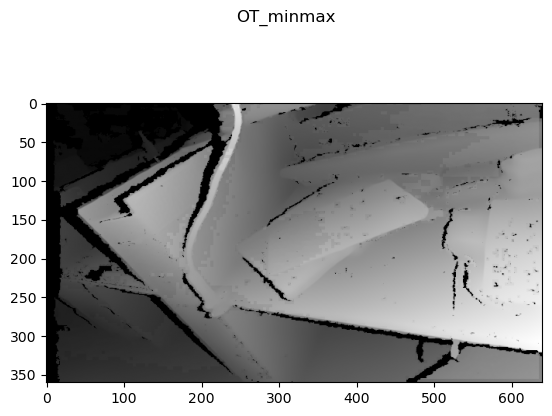

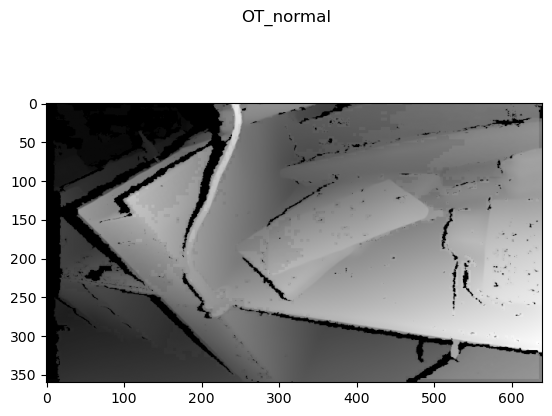

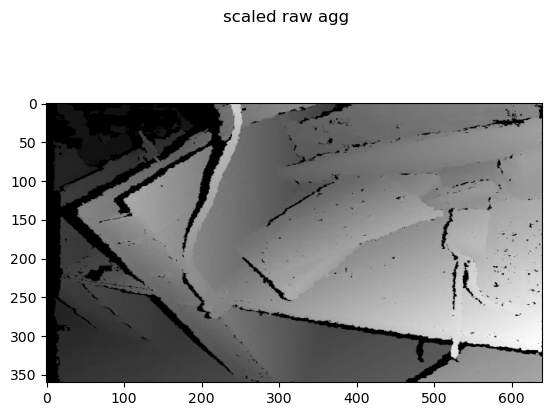

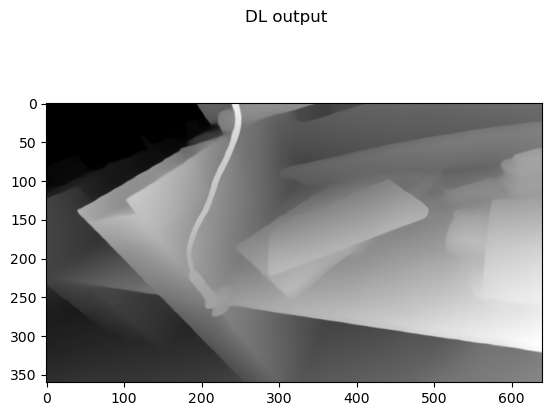

In [23]:
figure_show(cm_minmax_12, 1, title='OT_minmax')
figure_show(cm_normal_12, 2, title='OT_normal')
figure_show(cm_scaled_agg_12, 3, title='scaled raw agg')
figure_show(cm_scaled_dl_12, 4, title='DL output')

Now we want to find the maximum/minimum difference between the OT output and original AGG output as well as the location.

In [24]:
diff_minmax_agg_12 = minmax_12 - scaled_agg_12
diff_normal_agg_12 = normal_12 - scaled_agg_12

cm_diff_minmax_agg_12 = apply_colormap(diff_minmax_agg_12)
cm_diff_normal_agg_12 = apply_colormap(diff_normal_agg_12)

/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


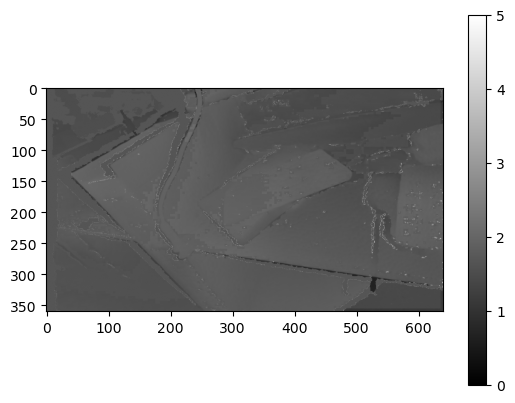

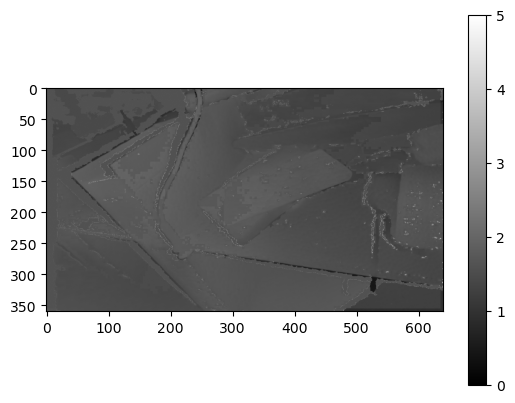

In [25]:
figure_show(cm_diff_minmax_agg_12, 1, 0, 5, True)
figure_show(cm_diff_normal_agg_12, 2, 0, 5, True)

In [26]:
print(f"The maxmimum difference between OT_minmax and agg is {np.max(diff_minmax_agg_12)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_12 == np.max(diff_minmax_agg_12))}")
print(f"The minimum difference between OT_minmax and agg is {np.min(diff_minmax_agg_12)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_12 == np.min(diff_minmax_agg_12))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_12)}, whereas the max value is {np.max(scaled_agg_12)}")
print(f"The min value of OT_minmax output is {np.min(minmax_12)}, whereas the max value is {np.max(minmax_12)}")

The maxmimum difference between OT_minmax and agg is 132.53077845180854
where with the subscripts of (array([243]), array([636]))
The minimum difference between OT_minmax and agg is -66.70839076494373
where with the subscripts of (array([318]), array([614]))
The min value of original AGG output is 0.0, whereas the max value is 163.86900603976474
The min value of OT_minmax output is 0.0, whereas the max value is 163.86900603976474


In [27]:
print(f"The maxmimum difference between OT_normal and agg is {np.max(diff_normal_agg_12)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_12 == np.max(diff_normal_agg_12))}")
print(f"The minimum difference between OT_normal and agg is {np.min(diff_normal_agg_12)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_12 == np.min(diff_normal_agg_12))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_12)}, whereas the max value is {np.max(scaled_agg_12)}")
print(f"The min value of OT_normal output is {np.min(normal_12)}, whereas the max value is {np.max(normal_12)}")

The maxmimum difference between OT_normal and agg is 125.81974312801826
where with the subscripts of (array([243]), array([636]))
The minimum difference between OT_normal and agg is -57.0353737295417
where with the subscripts of (array([8]), array([240]))
The min value of original AGG output is 0.0, whereas the max value is 163.86900603976474
The min value of OT_normal output is 1.9988018344052563, whereas the max value is 159.0052507349633


### For data 19

We finally move our eyes to input data 19.

In [28]:
ot_minmax_path_19 = '/Users/williamwei/Codes/disp-refine-by-DL/data/19/OT_minmax_0222_agg.mat'
ot_normal_path_19 = '/Users/williamwei/Codes/disp-refine-by-DL/data/19/OT_normal_0222_agg.mat'
scaled_agg_path_19 = '/Users/williamwei/Codes/disp-refine-by-DL/data/19/scaled_0222_agg.mat'
dl_path_19 = '/Users/williamwei/Codes/disp-refine-by-DL/data/19/output_0222_DL.npy'

We load the binary file into numpy arrary and dipict them with colormap to visualize.

In [29]:
minmax_19 = load_disp_from_mat(ot_minmax_path_19, DATASET_NAME)
normal_19 = load_disp_from_mat(ot_normal_path_19, DATASET_NAME)
scaled_agg_19 = load_disp_from_mat(scaled_agg_path_19, DATASET_NAME)
dl_19 = np.load(dl_path_19)
scaled_dl_19 = image_resize(dl_19, (scaled_agg_19.shape[0], scaled_agg_19.shape[1]))


cm_minmax_19 = apply_colormap(minmax_19)
cm_normal_19 = apply_colormap(normal_19)
cm_scaled_agg_19 = apply_colormap(scaled_agg_19)
cm_scaled_dl_19 = apply_colormap(scaled_dl_19)

Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>
Keys: <KeysViewHDF5 ['data']>


/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


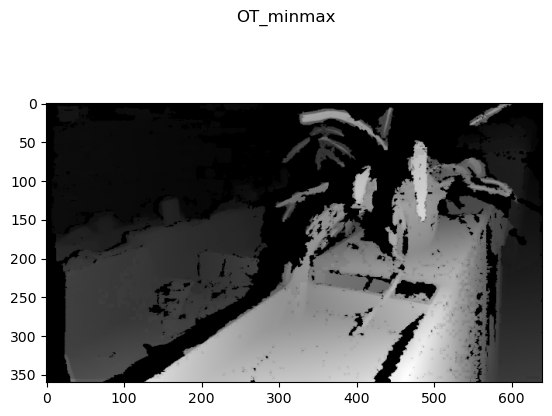

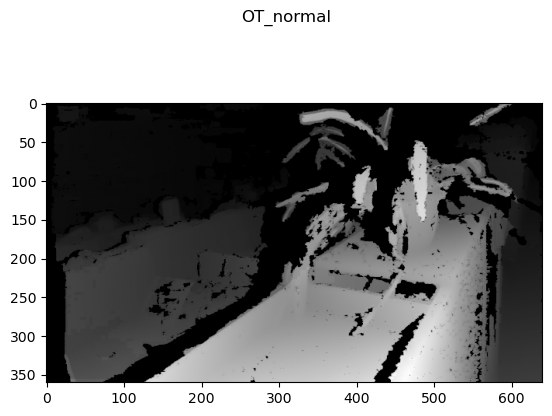

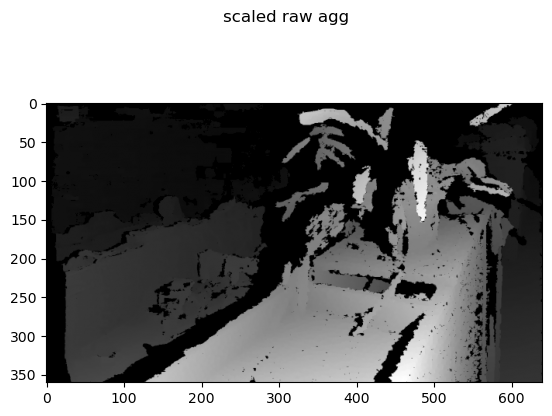

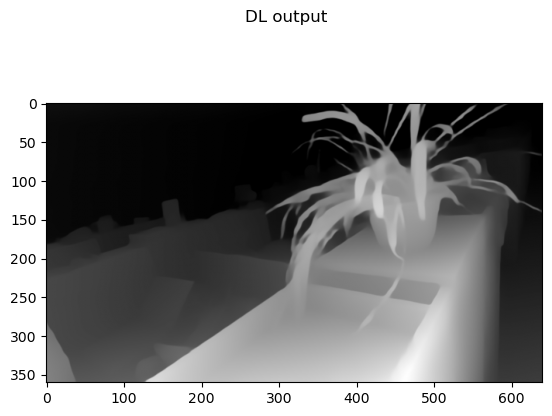

In [30]:
figure_show(cm_minmax_19, 1, title='OT_minmax')
figure_show(cm_normal_19, 2, title='OT_normal')
figure_show(cm_scaled_agg_19, 3, title='scaled raw agg')
figure_show(cm_scaled_dl_19, 4, title='DL output')

Now we want to find the maximum/minimum difference between the OT output and original AGG output as well as the location.

In [31]:
diff_minmax_agg_19 = minmax_19 - scaled_agg_19
diff_normal_agg_19 = normal_19 - scaled_agg_19

cm_diff_minmax_agg_19 = apply_colormap(diff_minmax_agg_19)
cm_diff_normal_agg_19 = apply_colormap(diff_normal_agg_19)

/var/folders/h9/ylw6m9b51hv5f2rn_wywkdl00000gn/T/ipykernel_61731/2811836574.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


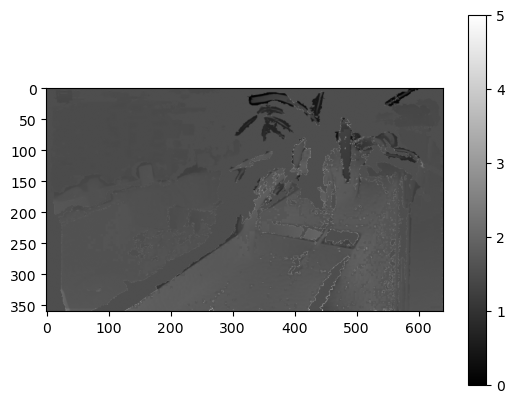

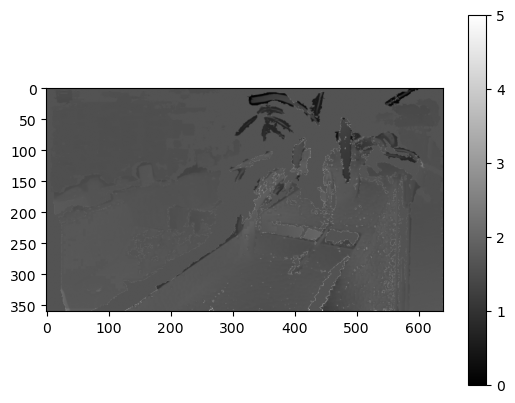

In [32]:
figure_show(cm_diff_minmax_agg_19, 1, 0, 5, True)
figure_show(cm_diff_normal_agg_19, 2, 0, 5, True)

In [33]:
print(f"The maxmimum difference between OT_minmax and agg is {np.max(diff_minmax_agg_19)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_19 == np.max(diff_minmax_agg_19))}")
print(f"The minimum difference between OT_minmax and agg is {np.min(diff_minmax_agg_19)}")
print(f"where with the subscripts of {np.where(diff_minmax_agg_19 == np.min(diff_minmax_agg_19))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_19)}, whereas the max value is {np.max(scaled_agg_19)}")
print(f"The min value of OT_minmax output is {np.min(minmax_19)}, whereas the max value is {np.max(minmax_19)}")

The maxmimum difference between OT_minmax and agg is 201.18982256307706
where with the subscripts of (array([358]), array([445]))
The minimum difference between OT_minmax and agg is -89.57562484367594
where with the subscripts of (array([1]), array([601]))
The min value of original AGG output is 0.0, whereas the max value is 227.77353086424966
The min value of OT_minmax output is 0.0, whereas the max value is 227.77353086424966


In [34]:
print(f"The maxmimum difference between OT_normal and agg is {np.max(diff_normal_agg_19)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_19 == np.max(diff_normal_agg_19))}")
print(f"The minimum difference between OT_normal and agg is {np.min(diff_normal_agg_19)}")
print(f"where with the subscripts of {np.where(diff_normal_agg_19 == np.min(diff_normal_agg_19))}")
print(f"The min value of original AGG output is {np.min(scaled_agg_19)}, whereas the max value is {np.max(scaled_agg_19)}")
print(f"The min value of OT_normal output is {np.min(normal_19)}, whereas the max value is {np.max(normal_19)}")

The maxmimum difference between OT_normal and agg is 187.91723886816612
where with the subscripts of (array([358]), array([445]))
The minimum difference between OT_normal and agg is -88.21308566287081
where with the subscripts of (array([1]), array([601]))
The min value of original AGG output is 0.0, whereas the max value is 227.77353086424966
The min value of OT_normal output is 1.3786643541611703, whereas the max value is 215.7177110124071


## Conclusion

As noticed by these simple comparisons, we can conclude that it is feasible of optimal transportation to correct or refine the disparity output generated by AGG. However, it has several limitations and drawbacks:

- It is strongly dependant by deep learning result.(neural network)
- The accuracy tolerance(change the value of disparity sharply in pixelwise) cannot satisfy our requirments.
- May occur some unexpected side effects.(i.e. empty horizontal line due to the mismatched distribution estimation)

However, it is surely a great way to try and explore. But I may suspend this project for a while to do other urgent commands.